## **Importing Libraries**

In [ ]:
!pip install pydub

In [ ]:
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
import os
import h5py
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import shutil
import soundfile as sf
import pandas as pd
from google.colab import files
from pydub import AudioSegment
from tqdm import tqdm
from tensorflow.image import resize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Downloading Data**

In [ ]:
files.upload()
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d imsparsh/fma-free-music-archive-small-medium

In [ ]:
!unzip 'fma-free-music-archive-small-medium.zip'

In [ ]:
import os

dataset_path = "/content/drive/MyDrive/FMA_DATASET"

if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)
    print(f"✅ Created folder: {dataset_path}")
else:
    print(f"📂 Folder already exists: {dataset_path}")

print("🚀 Moving fma_medium with progress...")
!rsync -av --ignore-existing --progress "/content/fma_medium/" "/content/drive/MyDrive/FMA_DATASET/fma_medium/"

print("\n🚀 Moving fma_small with progress...")
!rsync -av --ignore-existing --progress "/content/fma_small/" "/content/drive/MyDrive/FMA_DATASET/fma_small/"

print("\n🚀 Moving fma_metadata with progress...")
!rsync -av --ignore-existing --progress "/content/fma_metadata/" "/content/drive/MyDrive/FMA_DATASET/fma_metadata/"

# 4️⃣ Verify files in FMA_DATASET
files = os.listdir(dataset_path)
print("\n📂 Files in FMA_DATASET:", files)

# 5️⃣ OPTIONAL: Delete the original folders to free space (Uncomment if needed)
# print("\n🗑️ Deleting original folders to free space...")
# !rm -rf "/content/fma_medium"
# !rm -rf "/content/fma_small"
# !rm -rf "/content/fma_metadata"

print("\n✅ All FMA datasets have been successfully moved to Google Drive!")

In [ ]:
import os

dataset_path = "/content/drive/MyDrive/FMA_DATASET"

folders = ["fma_small", "fma_medium", "fma_metadata"]

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

for folder in folders:
    folder_path = os.path.join(dataset_path, folder)
    if os.path.exists(folder_path):
        file_count = sum([len(files) for _, _, files in os.walk(folder_path)])
        print(f"📂 {folder}: {file_count} dosya")
    else:
        print(f"⚠ {folder} klasörü bulunamadı!")


Mounted at /content/drive
📂 fma_small: 4089 dosya
📂 fma_medium: 25002 dosya
📂 fma_metadata: 12 dosya


In [ ]:
!ls -lh "/content/drive/MyDrive/FMA_DATASET/fma_medium/" | head -20

total 4.0K
drwx------ 158 root root 4.0K Feb 27 15:51 fma_medium


In [ ]:
!ls -lh "/content/drive/MyDrive/FMA_DATASET/fma_small/" | head -20

total 4.0K
drwx------ 158 root root 4.0K Feb 27 15:53 fma_small


In [ ]:
!du -sh "/content/drive/MyDrive/FMA_DATASET/fma_medium"

24G	/content/drive/MyDrive/FMA_DATASET/fma_medium


In [ ]:
!du -sh "/content/drive/MyDrive/FMA_DATASET/fma_small"

3.8G	/content/drive/MyDrive/FMA_DATASET/fma_small


In [ ]:
import os
import pandas as pd

# Google Drive bağlantısını yap
from google.colab import drive
drive.mount('/content/drive')

# FMA dataset yolunu tanımla
dataset_path = "/content/drive/MyDrive/FMA_DATASET"
medium_audio_path = os.path.join(dataset_path, "fma_medium")
metadata_path = os.path.join(dataset_path, "fma_metadata")

# 1️⃣ Toplam dosya sayısını bul
total_files = sum([len(files) for _, _, files in os.walk(medium_audio_path)])
print(f"🎵 Toplam Şarkı Sayısı: {total_files}")

# 2️⃣ tracks.csv'yi yükle ve türlere göre say
tracks_csv_path = os.path.join(metadata_path, "tracks.csv")

if os.path.exists(tracks_csv_path):
    # CSV dosyasını oku
    tracks_df = pd.read_csv(tracks_csv_path, index_col=0, header=[0, 1])

    # Sadece şarkı ID'si ve tür bilgisini al
    genre_data = tracks_df[[("track", "genre_top")]].dropna()
    genre_data.columns = ["genre_top"]

    # Tür bazında şarkı sayılarını hesapla
    genre_counts = genre_data["genre_top"].value_counts()

    # Sonucu yazdır
    print("\n🎵 Türlere Göre Şarkı Dağılımı:")
    print(genre_counts)
else:
    print("⚠ tracks.csv dosyası bulunamadı!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🎵 Toplam Şarkı Sayısı: 25002

🎵 Türlere Göre Şarkı Dağılımı:
genre_top
Rock                   14182
Experimental           10608
Electronic              9372
Hip-Hop                 3552
Folk                    2803
Pop                     2332
Instrumental            2079
International           1389
Classical               1230
Jazz                     571
Old-Time / Historic      554
Spoken                   423
Country                  194
Soul-RnB                 175
Blues                    110
Easy Listening            24
Name: count, dtype: int64


In [ ]:
classes = [
    "Rock", "Experimental", "Electronic", "Hip-Hop", "Folk",
    "Pop", "Instrumental", "International", "Classical", "Jazz",
    "Old-Time / Historic", "Spoken", "Country", "Soul-RnB",
    "Blues", "Easy Listening"
]

## **Convertin fma_medium to WAV**

In [ ]:
!apt-get update
!apt-get install -y ffmpeg

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,321 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,705 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-sec

In [ ]:
dataset_path = "/content/drive/MyDrive/FMA_DATASET"
audio_path = os.path.join(dataset_path, "fma_medium")
wav_output_path = os.path.join(dataset_path, "fma_medium_wav")

os.makedirs(wav_output_path, exist_ok=True)

successful_conversions = 0
failed_conversions = 0

for root, dirs, files in os.walk(audio_path):
    for file in files:
        if file.endswith('.mp3'):
            mp3_path = os.path.join(root, file)
            relative_path = os.path.relpath(root, audio_path)
            wav_folder = os.path.join(wav_output_path, relative_path)
            os.makedirs(wav_folder, exist_ok=True)

            wav_path = os.path.join(wav_folder, file.replace('.mp3', '.wav'))

            if os.path.exists(wav_path):
                print(f"⏭️ Atlama: {wav_path} (Zaten mevcut)")
                continue
            try:
                print(f"🔊 {mp3_path} -> {wav_path}")
                audio = AudioSegment.from_mp3(mp3_path)
                audio.export(wav_path, format="wav")
                successful_conversions += 1
            except Exception as e:
                print(f"❌ Hata: {mp3_path} -> {wav_path} ({str(e)})")
                failed_conversions += 1

print(f"\n✅ Başarıyla dönüştürülen dosya sayısı: {successful_conversions}")
print(f"❌ Hata veren dosya sayısı: {failed_conversions}")

Görüntülenen çıkış son 5000 satıra kısaltıldı.
🔊 /content/drive/MyDrive/FMA_DATASET/fma_medium/fma_medium/124/124748.mp3 -> /content/drive/MyDrive/FMA_DATASET/fma_medium_wav/fma_medium/124/124748.wav
🔊 /content/drive/MyDrive/FMA_DATASET/fma_medium/fma_medium/124/124871.mp3 -> /content/drive/MyDrive/FMA_DATASET/fma_medium_wav/fma_medium/124/124871.wav
🔊 /content/drive/MyDrive/FMA_DATASET/fma_medium/fma_medium/124/124869.mp3 -> /content/drive/MyDrive/FMA_DATASET/fma_medium_wav/fma_medium/124/124869.wav
🔊 /content/drive/MyDrive/FMA_DATASET/fma_medium/fma_medium/124/124870.mp3 -> /content/drive/MyDrive/FMA_DATASET/fma_medium_wav/fma_medium/124/124870.wav
🔊 /content/drive/MyDrive/FMA_DATASET/fma_medium/fma_medium/124/124754.mp3 -> /content/drive/MyDrive/FMA_DATASET/fma_medium_wav/fma_medium/124/124754.wav
🔊 /content/drive/MyDrive/FMA_DATASET/fma_medium/fma_medium/124/124875.mp3 -> /content/drive/MyDrive/FMA_DATASET/fma_medium_wav/fma_medium/124/124875.wav
🔊 /content/drive/MyDrive/FMA_DATASE

In [ ]:
import os
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/FMA_DATASET"
wav_audio_path = os.path.join(dataset_path, "fma_medium_wav")
metadata_path = os.path.join(dataset_path, "fma_metadata")

total_wav_files = sum([len(files) for _, _, files in os.walk(wav_audio_path)])
print(f"🎵 Toplam WAV Şarkı Sayısı: {total_wav_files}")

tracks_csv_path = os.path.join(metadata_path, "tracks.csv")

if os.path.exists(tracks_csv_path):
    tracks_df = pd.read_csv(tracks_csv_path, index_col=0, header=[0, 1])

    genre_data = tracks_df[[("track", "genre_top")]].dropna()
    genre_data.columns = ["genre_top"]

    genre_counts = {}
    for root, _, files in os.walk(wav_audio_path):
        for file in files:
            if file.endswith(".wav"):
                track_id = int(file.replace(".wav", ""))

                if track_id in genre_data.index:
                    genre = genre_data.loc[track_id, "genre_top"]
                    genre_counts[genre] = genre_counts.get(genre, 0) + 1

    print("\n🎵 Türlere Göre WAV Şarkı Dağılımı:")
    for genre, count in sorted(genre_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"  - {genre}: {count} şarkı")

else:
    print("⚠ tracks.csv dosyası bulunamadı!")

print(f"Türe atanamayan şarkı sayısı: {total_wav_files - sum(genre_counts.values())}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🎵 Toplam WAV Şarkı Sayısı: 24985

🎵 Türlere Göre WAV Şarkı Dağılımı:
  - Rock: 7098 şarkı
  - Electronic: 6311 şarkı
  - Experimental: 2250 şarkı
  - Hip-Hop: 2197 şarkı
  - Folk: 1518 şarkı
  - Instrumental: 1349 şarkı
  - Pop: 1186 şarkı
  - International: 1018 şarkı
  - Classical: 619 şarkı
  - Old-Time / Historic: 510 şarkı
  - Jazz: 384 şarkı
  - Country: 178 şarkı
  - Soul-RnB: 154 şarkı
  - Spoken: 118 şarkı
  - Blues: 74 şarkı
  - Easy Listening: 21 şarkı
Türe atanamayan şarkı sayısı: 0


## **Visualizing Single Audio**

In [ ]:
dataSetPath = '/content/drive/MyDrive/FMA_DATASET/fma_medium_wav/fma_medium/155'
audioName = dataSetPath + '/155000.wav'

print(os.listdir(dataSetPath))

['155000.mp3', '155063.mp3', '155064.mp3', '155065.mp3', '155066.mp3', '155108.mp3', '155130.mp3', '155138.mp3', '155140.mp3', '155141.mp3', '155142.mp3', '155289.mp3', '155290.mp3', '155291.mp3', '155292.mp3', '155293.mp3', '155294.mp3', '155295.mp3', '155296.mp3', '155297.mp3', '155298.mp3', '155306.mp3', '155307.mp3', '155314.mp3']


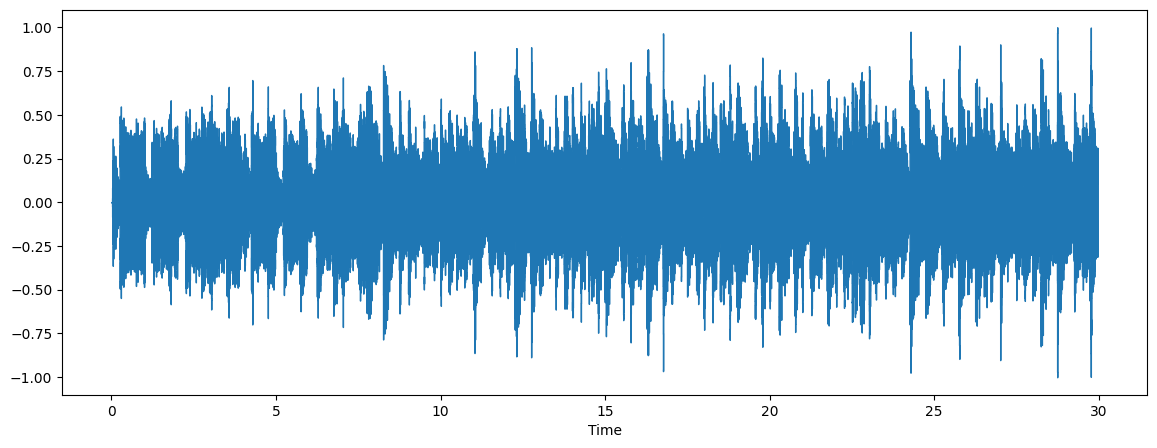

In [ ]:
y,sr = librosa.load(audioName, sr = 44100)
plt.figure(figsize = (14,5))
librosa.display.waveshow(y, sr = sr)

In [ ]:
from IPython.display import Audio
Audio(data = y, rate = sr)

Output hidden; open in https://colab.research.google.com to view.

## **Visualization Chunks of the Single Audio**

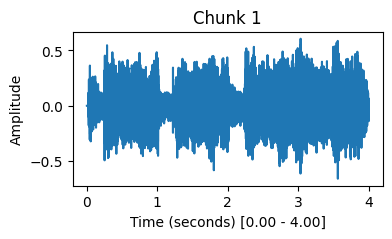

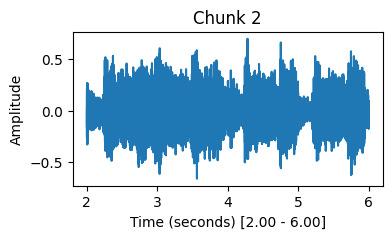

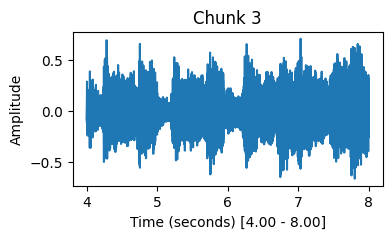

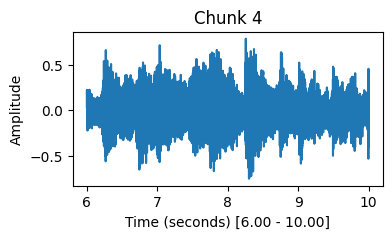

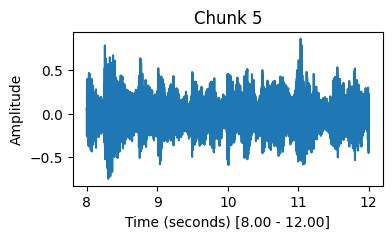

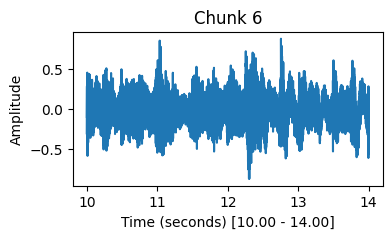

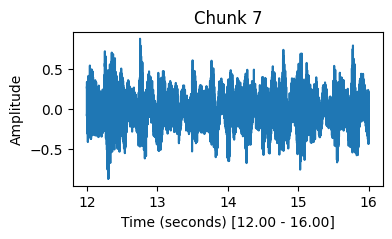

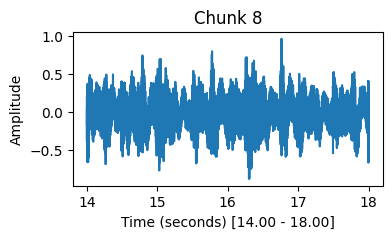

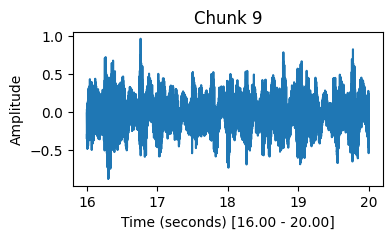

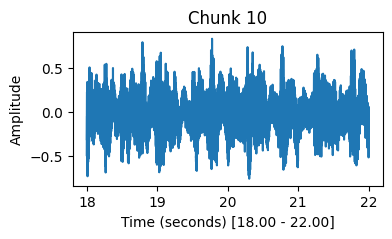

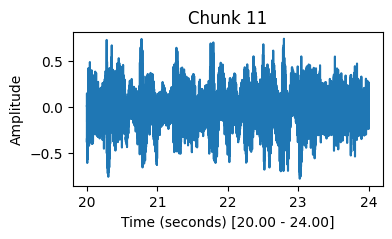

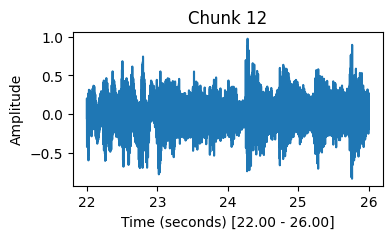

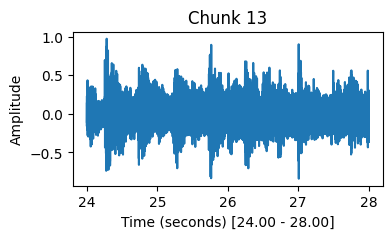

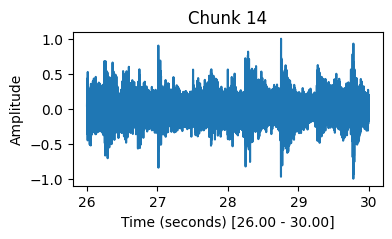

In [ ]:
dataSetPath = '/content/drive/MyDrive/FMA_DATASET/fma_medium_wav/fma_medium'
audioName = dataSetPath + '/155/155000.wav'
y,sr = librosa.load(audioName, sr = None) # sr = None deme sebebimiz, orjinal 'sample rate' değerini korumak istememiz.

chunkDuration = 4
overlapDuration = 2

# Convert duration to sample
chunkSamples = chunkDuration * sr
overlapSamples = overlapDuration * sr

# Chunk number calculation
numChunks = int(np.ceil((len(y) - chunkSamples) / (chunkSamples - overlapSamples))) + 1

# Iterate over each chunks
for i in range(numChunks):
    start = i * (chunkSamples - overlapSamples)
    end = start + chunkSamples
    chunk = y[start:end]

    start_time_sec = start / sr
    end_time_sec = end / sr

    time_axis = np.linspace(start_time_sec, end_time_sec, len(chunk))

    plt.figure(figsize=(4, 2))
    plt.plot(time_axis, chunk)
    plt.xlabel(f'Time (seconds) [{start_time_sec:.2f} - {end_time_sec:.2f}]')
    plt.ylabel('Amplitude')
    plt.title(f'Chunk {i+1}')
    plt.show()

## **Single Audio Melspectrogram**

In [ ]:
def plotMelspectrogram(y, sr):
  # Compute spectogram
  spectogram = librosa.feature.melspectrogram(y = y, sr = sr)
  # Conver to decibel
  spectogramDb = librosa.power_to_db(spectogram, ref = np.max)
  # Visualize the spectogram
  plt.figure(figsize = (10, 4))
  librosa.display.specshow(spectogramDb, sr = sr, x_axis = 'time', y_axis = 'mel')
  plt.colorbar(format = '%2.0f dB')
  plt.title("Spectogram")
  plt.tight_layout()
  plt.show()

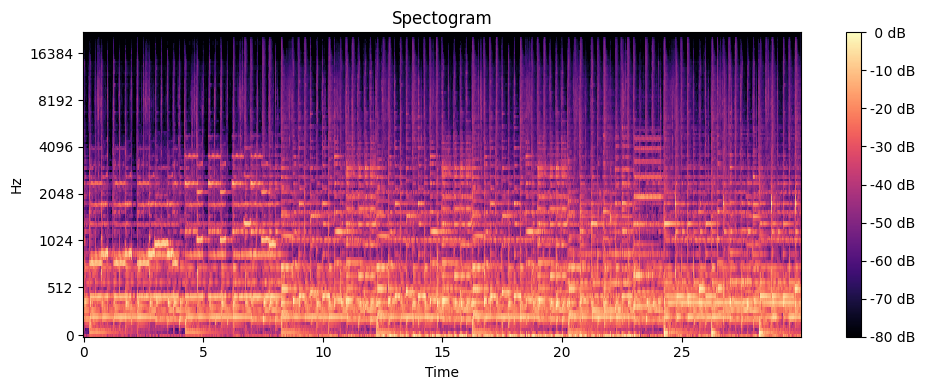

In [ ]:
dataSetPath = '/content/drive/MyDrive/FMA_DATASET/fma_medium/fma_medium'
audioName = dataSetPath + '/155/155000.mp3'
y,sr = librosa.load(audioName, sr = 44100)
plotMelspectrogram(y, sr)

## **Chunk's Melspectrogram Visualization**

In [ ]:
def plotMelspectrogramChunks(y, sr):
    chunkDuration = 4
    overlapDuration = 2

    chunkSamples = chunkDuration * sr
    overlapSamples = overlapDuration * sr

    numChunks = int(np.ceil((len(y) - chunkSamples) / (chunkSamples - overlapSamples))) + 1

    for i in range(numChunks):
        start = i * (chunkSamples - overlapSamples)
        end = start + chunkSamples
        chunk = y[start:end]

        start_time_sec = start / sr
        end_time_sec = end / sr

        spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sr)
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

        plt.figure(figsize=(10, 4))
        librosa.display.specshow(spectrogram_db, sr=sr, x_axis=None, y_axis='mel')
        plt.colorbar(format='%2.0f dB')
        plt.title(f'Chunk {i+1} Mel Spectrogram ({start_time_sec:.2f} - {end_time_sec:.2f} seconds)')

        num_ticks = 5
        time_ticks = np.linspace(0, spectrogram_db.shape[1], num_ticks)
        time_labels = np.linspace(start_time_sec, end_time_sec, num_ticks)
        plt.xticks(time_ticks, [f'{t:.2f}' for t in time_labels])

        plt.xlabel('Time (seconds)')
        plt.tight_layout()
        plt.show()

In [ ]:
dataSetPath = '/content/drive/MyDrive/FMA_DATASET/fma_medium_wav/fma_medium'
audioName = dataSetPath + '/155/155000.wav'
y,sr = librosa.load(audioName, sr = 44100)
plotMelspectrogramChunks(y = y, sr = sr)

Output hidden; open in https://colab.research.google.com to view.

## **All FMA Medium Data Set Melspectrogram**

In [ ]:
dataset_path = "/content/drive/MyDrive/FMA_DATASET"
audio_path = os.path.join(dataset_path, "fma_medium_wav/fma_medium")
metadata_path = os.path.join(dataset_path, "fma_metadata")

tracks_csv_path = os.path.join(metadata_path, "tracks.csv")
tracks_df = pd.read_csv(tracks_csv_path, index_col=0, header=[0, 1])

genre_data = tracks_df[[("track", "genre_top")]].dropna()
genre_data.columns = ["genre_top"]

genre_classes = genre_data["genre_top"].unique().tolist()
print("Türler:", genre_classes)

id_to_genre = genre_data.to_dict()["genre_top"]

chunk_duration = 4
overlap_duration = 2

def MelspectrogramChunks(y, sr, targetShape, data, labels, genre):
    chunkSamples = chunk_duration * sr
    overlapSamples = overlap_duration * sr
    numChunks = int(np.ceil((len(y) - chunkSamples) / (chunkSamples - overlapSamples))) + 1

    for i in range(numChunks):
        start = i * (chunkSamples - overlapSamples)
        end = start + chunkSamples
        chunk = y[start:end]

        if len(chunk) < chunkSamples:
            pad_width = chunkSamples - len(chunk)
            chunk = np.pad(chunk, (0, pad_width), mode='constant')

        spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sr)
        spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        resizedSpectrogram = resize(np.expand_dims(spectrogram, axis=-1), targetShape)

        data.append(resizedSpectrogram)
        labels.append(genre_classes.index(genre))

def loadAndPreprocessData(audio_path, targetShape=(128, 128)):
    data, labels = [], []
    for folder in sorted(os.listdir(audio_path)):
        folder_path = os.path.join(audio_path, folder)
        if os.path.isdir(folder_path):
            print(f"İşleniyor: {folder}")
            for file in os.listdir(folder_path):
                if file.endswith('.wav'):
                    file_id = int(file.split('.')[0])
                    file_path = os.path.join(folder_path, file)
                    if file_id in id_to_genre:
                        try:
                            audioData, sampleRate = librosa.load(file_path, sr=None)
                            MelspectrogramChunks(audioData, sampleRate, targetShape, data, labels, id_to_genre[file_id])
                        except Exception as e:
                            print(f"⚠ {file_path} atlandı. Hata: {e}")
    return np.array(data), np.array(labels)

data, labels = loadAndPreprocessData(audio_path)

labels = to_categorical(labels, num_classes=len(genre_classes))

Türler: ['Hip-Hop', 'Pop', 'Rock', 'Experimental', 'Folk', 'Jazz', 'Electronic', 'Spoken', 'International', 'Soul-RnB', 'Blues', 'Country', 'Classical', 'Old-Time / Historic', 'Instrumental', 'Easy Listening']
İşleniyor: 000
İşleniyor: 001
İşleniyor: 002
İşleniyor: 003
İşleniyor: 004
İşleniyor: 005
İşleniyor: 006
İşleniyor: 007
İşleniyor: 008
İşleniyor: 009
İşleniyor: 010
İşleniyor: 011
İşleniyor: 012
İşleniyor: 013
İşleniyor: 014
İşleniyor: 015
İşleniyor: 016
İşleniyor: 017
İşleniyor: 018
İşleniyor: 019
İşleniyor: 020
İşleniyor: 021
İşleniyor: 022
İşleniyor: 023
İşleniyor: 024
İşleniyor: 025
İşleniyor: 026
İşleniyor: 027
İşleniyor: 028
İşleniyor: 029
İşleniyor: 030
İşleniyor: 031
İşleniyor: 032
İşleniyor: 033
İşleniyor: 034
İşleniyor: 035
İşleniyor: 036
İşleniyor: 037
İşleniyor: 038
İşleniyor: 039
İşleniyor: 040
İşleniyor: 041
İşleniyor: 042
İşleniyor: 043
İşleniyor: 044
İşleniyor: 045
İşleniyor: 046
İşleniyor: 047
İşleniyor: 048
İşleniyor: 049
İşleniyor: 050
İşleniyor: 051
İşleniyor:

In [ ]:
print(f"🎵 Toplam Örnek Sayısı: {len(data)}")
print(f"📊 Veri Şekli: {data.shape}, Etiket Şekli: {labels.shape}")

🎵 Toplam Örnek Sayısı: 360191
📊 Veri Şekli: (360191, 128, 128, 1), Etiket Şekli: (360191, 16)


In [ ]:
import collections
from collections import Counter

label_counts = Counter(labels.argmax(axis=1))

print("🎵 Tür Dağılımı:")
for genre_index, count in sorted(label_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  - {genre_classes[genre_index]}: {count} örnek")


🎵 Tür Dağılımı:
  - Rock: 102239 örnek
  - Electronic: 91095 örnek
  - Experimental: 32446 örnek
  - Hip-Hop: 31618 örnek
  - Folk: 21907 örnek
  - Instrumental: 19408 örnek
  - Pop: 17123 örnek
  - International: 14689 örnek
  - Classical: 8902 örnek
  - Old-Time / Historic: 7349 örnek
  - Jazz: 5541 örnek
  - Country: 2574 örnek
  - Soul-RnB: 2230 örnek
  - Spoken: 1698 örnek
  - Blues: 1070 örnek
  - Easy Listening: 302 örnek


In [ ]:
save_path = "/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/"

np.save(os.path.join(save_path, "data.npy"), data)
np.save(os.path.join(save_path, "labels.npy"), labels)

print(f"✅ Veriler başarıyla kaydedildi: {save_path}")

✅ Veriler başarıyla kaydedildi: /content/drive/MyDrive/Music Genre Classification/Models/FMA_MEDIUM/


In [ ]:
load_path = "/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/"

data_file = os.path.join(load_path, "data.npy")
labels_file = os.path.join(load_path, "labels.npy")

if os.path.exists(data_file) and os.path.exists(labels_file):
    print("✅ Veriler Drive'da bulundu! Şimdi yükleniyor...")

    data = np.load(data_file)
    labels = np.load(labels_file)

    print(f"🎵 Data Şekli: {data.shape}")
    print(f"🎼 Labels Şekli: {labels.shape}")
else:
    print("⚠ Veriler Drive'da bulunamadı! Kaydın tamamlanıp tamamlanmadığını tekrar kontrol et.")

✅ Veriler Drive'da bulundu! Şimdi yükleniyor...
🎵 Data Şekli: (360191, 128, 128, 1)
🎼 Labels Şekli: (360191, 16)


## **Splitting Dataset into Training and Test Set**

In [ ]:
XTrain, XTest, YTrain, YTest = train_test_split(data, labels, test_size = 0.2, random_state = 42)

In [ ]:
np.save('/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/XTrain.npy', XTrain)
np.save('/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/YTrain.npy', YTrain)
np.save('/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/XTest.npy', XTest)
np.save('/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/YTest.npy', YTest)

In [ ]:
x_train_path = '/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/XTrain.npy'
y_train_path = '/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/YTrain.npy'
x_test_path = '/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/XTest.npy'
y_test_path = '/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/YTest.npy'

XTrain = np.load(x_train_path)
YTrain = np.load(y_train_path)
XTest = np.load(x_test_path)
YTest = np.load(y_test_path)

hdf5_path = '/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/data.h5'

with h5py.File(hdf5_path, 'w') as f:
    f.create_dataset('XTrain', data=XTrain, compression="gzip")
    f.create_dataset('YTrain', data=YTrain, compression="gzip")
    f.create_dataset('XTest', data=XTest, compression="gzip")
    f.create_dataset('YTest', data=YTest, compression="gzip")

print("Veri HDF5 formatına kaydedildi.")

Veri HDF5 formatına kaydedildi.


In [ ]:
file_paths = [
    "/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/XTrain.npy",
    "/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/YTrain.npy",
    "/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/XTest.npy",
    "/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/YTest.npy"
]

for file_path in file_paths:
    if os.path.exists(file_path):
        print(f"Dosya bulundu: {file_path}")
    else:
        print(f"Dosya bulunamadı: {file_path}")


Dosya bulundu: /content/drive/My Drive/Music Genre Classification/Models/FMA_MEDIUM/XTrain.npy
Dosya bulundu: /content/drive/My Drive/Music Genre Classification/Models/FMA_MEDIUM/YTrain.npy
Dosya bulundu: /content/drive/My Drive/Music Genre Classification/Models/FMA_MEDIUM/XTest.npy
Dosya bulundu: /content/drive/My Drive/Music Genre Classification/Models/FMA_MEDIUM/YTest.npy


In [ ]:
x_train_path = '/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/XTrain.npy'
y_train_path = '/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/YTrain.npy'
x_test_path = '/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/XTest.npy'
y_test_path = '/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/YTest.npy'

XTrain = np.load(x_train_path)
YTrain = np.load(y_train_path)
XTest = np.load(x_test_path)
YTest = np.load(y_test_path)

NameError: name 'np' is not defined

In [ ]:
del XTrain
del XTest
del YTrain
del YTest

In [ ]:
XTrain[0].shape

(128, 128, 1)

## **Building Model**

In [ ]:
model = tf.keras.models.Sequential()

input_shape = (128, 128, 1)

model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = input_shape))
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides = 2))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides = 2))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 128, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides = 2))

model.add(Dropout(0.3))

model.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 256, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides = 2))

model.add(Conv2D(filters = 512, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 512, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides = 2))

model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(units = 1200, activation = 'relu'))

model.add(Dropout(0.45))

model.add(Dense(units = len(classes), activation = 'softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 62, 62, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 31, 31, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 29, 29, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1200)                │       2,458,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │          19,216 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 7,189,664 (27.43 MB)

 Trainable params: 7,189,664 (27.43 MB)

 Non-trainable params: 0 (0.00 B)

## **Compile the Model**

In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

## **Training the Model**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

hdf5_path = '/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/data.h5'
f = h5py.File(hdf5_path, 'r')

XTrain = f['XTrain']
YTrain = f['YTrain']
XTest = f['XTest']
YTest = f['YTest']

train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(XTrain, YTrain, batch_size=32)
test_generator = test_datagen.flow(XTest, YTest, batch_size=32)

trainingHistory = model.fit(train_generator, epochs=15, validation_data=test_generator)

f.close()

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9005/9005 ━━━━━━━━━━━━━━━━━━━━ 273s 29ms/step - accuracy: 0.5101 - loss: 1.5569 - val_accuracy: 0.6478 - val_loss: 1.1195
Epoch 2/15
9005/9005 ━━━━━━━━━━━━━━━━━━━━ 246s 27ms/step - accuracy: 0.6551 - loss: 1.0940 - val_accuracy: 0.6947 - val_loss: 0.9620
Epoch 3/15
9005/9005 ━━━━━━━━━━━━━━━━━━━━ 244s 27ms/step - accuracy: 0.7063 - loss: 0.9183 - val_accuracy: 0.7432 - val_loss: 0.7971
Epoch 4/15
9005/9005 ━━━━━━━━━━━━━━━━━━━━ 245s 27ms/step - accuracy: 0.7611 - loss: 0.7382 - val_accuracy: 0.7846 - val_loss: 0.6664
Epoch 5/15
9005/9005 ━━━━━━━━━━━━━━━━━━━━ 244s 27ms/step - accuracy: 0.8117 - loss: 0.5704 - val_accuracy: 0.8207 - val_loss: 0.5511
Epoch 6/15
9005/9005 ━━━━━━━━━━━━━━━━━━━━ 244s 27ms/step - accuracy: 0.8520 - loss: 0.4418 - val_accuracy: 0.8438 - val_loss: 0.4842
Epoch 7/15
9005/9005 ━━━━━━━━━━━━━━━━━━━━ 244s 27ms/step - accuracy: 0.8826 - loss: 0.3478 - val_accuracy: 0.8638 - val_loss: 0.4206
Epoch 8/15
9005/9005 ━━━━━━━━━━━━━━━━━━━━ 242s 27ms/step - accuracy: 0.9038 - lo

In [ ]:
del train_generator
del test_generator
del train_datagen
del test_datagen

## **Saving Model & Training Data**

In [ ]:
model.save('/content/drive/My Drive/Music Genre Classification/Models/FMA_MEDIUM/Trained_modelFMA.keras')

In [ ]:
import json
with open('/content/drive/My Drive/Music Genre Classification/Models/FMA_MEDIUM/trainingHistory.json', 'w') as f:
    json.dump(trainingHistory.history, f)

In [ ]:
from tensorflow.keras.models import load_model
loadedModel = load_model('/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/Trained_modelFMA.keras')

In [ ]:
import json

with open('/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/trainingHistory.json', 'r') as f:
    trainingHistoryData = json.load(f)

In [ ]:
trainingHistoryData.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
trainingHistoryData

In [ ]:
del trainingHistoryData
del trainingHistory
del model

## **Model Evaluation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

hdf5_path = "/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/data.h5"

with h5py.File(hdf5_path, 'r') as f:
    XTrain = f['XTrain']
    YTrain = f['YTrain']
    XTest = f['XTest']
    YTest = f['YTest']

    eval_datagen = ImageDataGenerator()

    train_eval_generator = eval_datagen.flow(XTrain, YTrain, batch_size=32)
    test_eval_generator = eval_datagen.flow(XTest, YTest, batch_size=32)

    trainLoss, trainAccuracy = loadedModel.evaluate(train_eval_generator)
    valLoss, valAccuracy = loadedModel.evaluate(test_eval_generator)

print(f"Train Loss: {trainLoss}, Train Accuracy: {trainAccuracy}")
print(f"Validation Loss: {valLoss}, Validation Accuracy: {valAccuracy}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9005/9005 ━━━━━━━━━━━━━━━━━━━━ 66s 7ms/step - accuracy: 0.9896 - loss: 0.0366
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9122 - loss: 0.3055
Train Loss: 0.03677023574709892, Train Accuracy: 0.9896513223648071
Validation Loss: 0.30240654945373535, Validation Accuracy: 0.9126722812652588


In [ ]:
results_path = "/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/evaluation_results.json"

with open(results_path, "r") as json_file:
    evaluation_results = json.load(json_file)

trainLoss = evaluation_results["train_loss"]
trainAccuracy = evaluation_results["train_accuracy"]
valLoss = evaluation_results["val_loss"]
valAccuracy = evaluation_results["val_accuracy"]

In [ ]:
del trainLoss
del trainAccuracy
del valLoss
del valAccuracy

## **Pushing & Pulling Evaluation Parameters**

In [ ]:
results_path = "/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/evaluation_results.json"

evaluation_results = {
    "train_loss": trainLoss,
    "train_accuracy": trainAccuracy,
    "val_loss": valLoss,
    "val_accuracy": valAccuracy
}

with open(results_path, "w") as json_file:
    json.dump(evaluation_results, json_file, indent=4)

## **Accuracy & Loss Visualization**

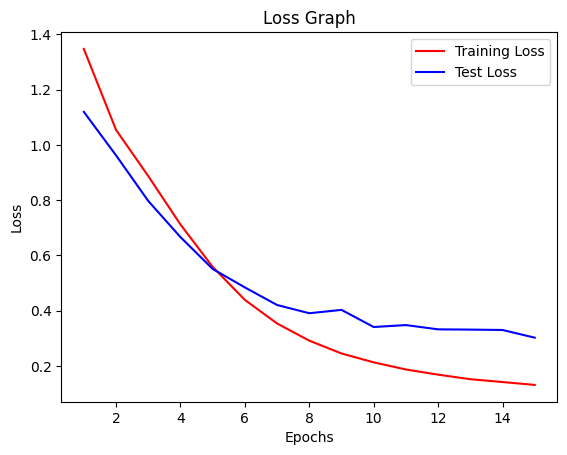

In [ ]:
epochs = [i for i in range(1, 16)]
plt.plot(epochs, trainingHistoryData['loss'], label = "Training Loss", color = 'red')
plt.plot(epochs, trainingHistoryData['val_loss'], label = "Test Loss", color = 'blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Graph")
plt.legend()
plt.show()

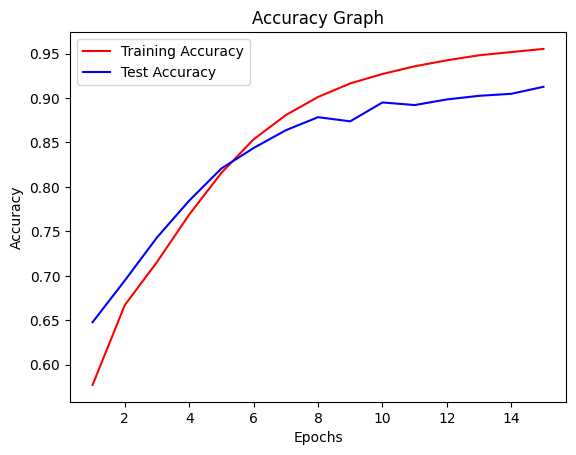

In [ ]:
epochs = [i for i in range(1, 16)]
plt.plot(epochs, trainingHistoryData['accuracy'], label = "Training Accuracy", color = 'red')
plt.plot(epochs, trainingHistoryData['val_accuracy'], label = "Test Accuracy", color = 'blue')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Graph")
plt.legend()
plt.show()

## **Metrics**

In [ ]:
hdf5_path = "/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/data.h5"

with h5py.File(hdf5_path, 'r') as f:
    XTest = f['XTest'][:]
    YTest = f['YTest'][:]

In [ ]:
print("XTest Shape:", XTest.shape)
print("YTest Shape:", YTest.shape)

XTest Shape: (72039, 128, 128, 1)
YTest Shape: (72039, 16)


In [ ]:
YPred = loadedModel.predict(XTest)
print("YPred Shape:", YPred.shape)

2252/2252 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step
YPred Shape: (72039, 16)


In [ ]:
predictedCategories = np.argmax(YPred, axis=1)
trueCategories = np.argmax(YTest, axis=1)

In [ ]:
print("Predicted Categories:", predictedCategories)
print("True Categories:", trueCategories)

Predicted Categories: [ 4  6  2 ...  2 13  8]
True Categories: [ 4  6  2 ...  2 13  8]


In [ ]:
cm = confusion_matrix(trueCategories, predictedCategories)
print(classification_report(trueCategories, predictedCategories, target_names=classes))

                     precision    recall  f1-score   support

               Rock       0.94      0.92      0.93      6307
       Experimental       0.83      0.81      0.82      3499
         Electronic       0.95      0.95      0.95     20417
            Hip-Hop       0.89      0.83      0.86      6392
               Folk       0.86      0.88      0.87      4413
                Pop       0.76      0.88      0.82      1086
       Instrumental       0.93      0.93      0.93     18326
      International       0.80      0.84      0.82       339
          Classical       0.92      0.89      0.90      2926
               Jazz       0.90      0.88      0.89       428
Old-Time / Historic       0.88      0.81      0.84       206
             Spoken       0.87      0.86      0.86       528
            Country       0.89      0.94      0.91      1772
           Soul-RnB       1.00      1.00      1.00      1501
              Blues       0.81      0.89      0.84      3841
     Easy Listening    

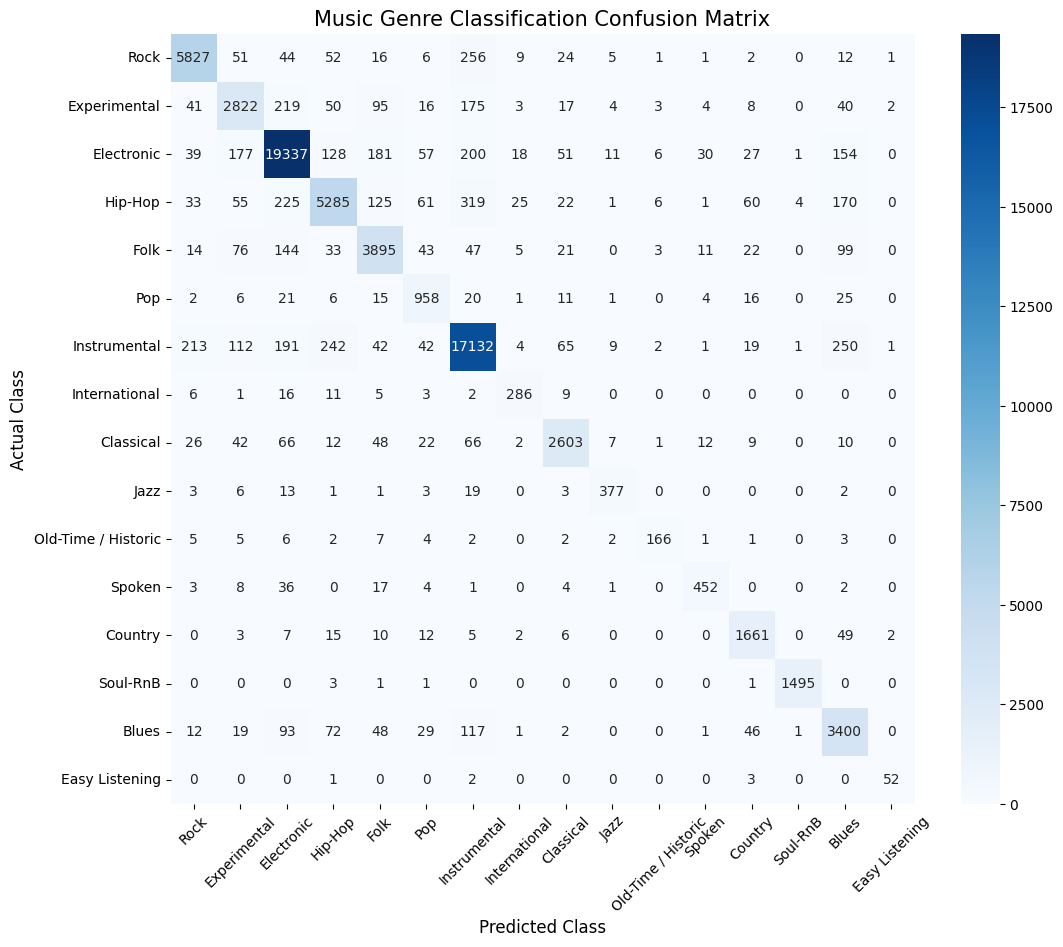

In [ ]:
cm = confusion_matrix(trueCategories, predictedCategories)

# Heatmap'i çizerken class isimlerini ekleyelim
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)  # Sınıf isimlerini ekliyoruz

plt.xlabel("Predicted Class", fontsize=12)
plt.ylabel("Actual Class", fontsize=12)
plt.title("Music Genre Classification Confusion Matrix", fontsize=15)
plt.xticks(rotation=45)  # X eksenindeki etiketleri açılı yaparak okunabilirliği artır
plt.yticks(rotation=0)  # Y eksenindeki etiketleri düz bırak
plt.show()

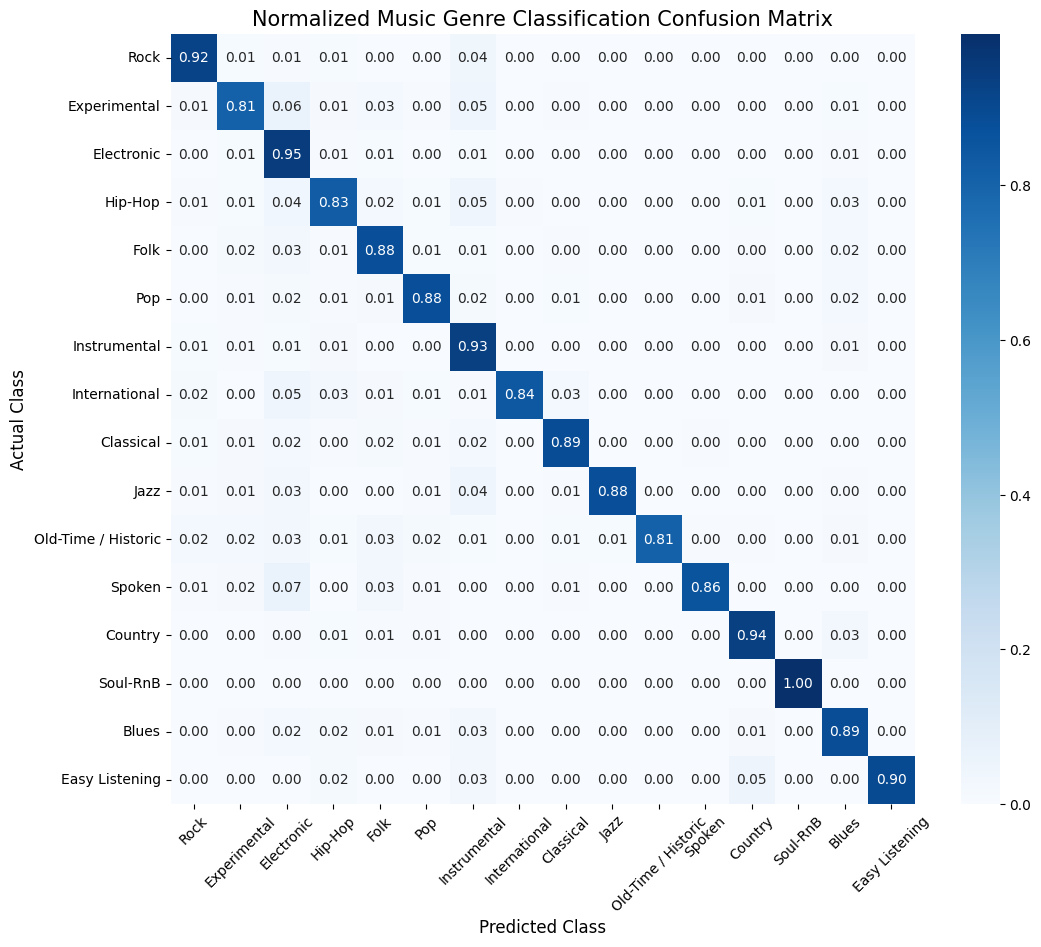

In [ ]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Normalized Heatmap Çizimi
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=classes, yticklabels=classes)  # Sınıf isimlerini ekledik

plt.xlabel("Predicted Class", fontsize=12)
plt.ylabel("Actual Class", fontsize=12)
plt.title("Normalized Music Genre Classification Confusion Matrix", fontsize=15)
plt.xticks(rotation=45)  # X ekseninde açılı yazı
plt.yticks(rotation=0)  # Y ekseni düz
plt.show()